#About the Data

* The data was taken from 
https://www.eba.europa.eu/sites/default/documents/files/documents/10180/2321183/b67323ac-27fa-482d-926e-ae7ba3e90cb8/Annex%20III%20%28Annex%205%20%28FINREP%29%29.pdf?msclkid=fc3c7b21b0af11ec8242e40ef60465b7

* The Data consist of four columns: Rule_number, Text, Topic and Character_count.<br>
  - Rule_number: FINREP Rule number.
  - Text: List of rules.
  - Topic: Category to which the rule belongs.
 -  Character_count: The number of characters in 'Text'.
 
* Each rule under the the headings<br>

  1. Equity
  2. Statement of profit or loss 
  3. Statement of comprehensive income 
  4. Breakdown of financial assets by instrument and by counterparty sector 
  5. Breakdown of non-trading loans and advances by product 
  6. Breakdown of non-trading loans and advances to non-financial corporations by NACE codes
  7. Financial assets subject to impairment that are past due 
  8. Breakdown of financial liabilities
  9. Loan commitments, financial guarantees and other commitments 
  10. Derivatives and hedge accounting
  11. Movements in allowances and provisions for credit losses
  12. Collateral and guarantees received 

are taken as a text (page 16 - 46)

* Rules are seperated by their rule number. For instance, 'Rule no. 175' and 'Rule no. 175i' are taken as seperate text.





# Text Preprocessing

* The line break ‘\n’ is removed from the text.

* Round and square parantheses are removed.

* Text contatined within round paranthesis are removed.

* Text contatined within square paranthesis are removed.

* No summarization was done.


#Fine Tuning DistilBERT model for text classification

* The model was trained on 30 epochs and the learning rate was set at 2e-5 and batch size 8

* Total time taken to create the dataframe with top 3 rank of predictions in the test data is : 0:00:27 (h:mm:ss)

* Data Split:<br>
      -Training data: 85 (About 51.51 percent)
      -Validation data: 40 (About 24.24 percent)
      -Test Data : 40 (About 24.24 percent)

* Macro-averaged f1-score<br>
      -Training data: 1.00
      -Validation data: 0.56
      -Test data: 0.39 



##Memory Allocated

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
saved_path = '/content/drive/MyDrive/Full_Code/FINREP/Parentheses_Removed/Epochs_30/'
used_test_data_path = saved_path  + "Test_data_DistilBERT.csv"

## Set-up environment

Install the libraries folium version 0.2.1, HuggingFace Transformers and Datasets

In [ ]:
#Install the package folium version 0.2.1 and HuggingFace tranformer and datasets libraries  
!pip install -q folium==0.2.1 transformers datasets 

     |████████████████████████████████| 69 kB 3.4 MB/s 
     |████████████████████████████████| 4.2 MB 10.7 MB/s 
     |████████████████████████████████| 346 kB 48.0 MB/s 
     |████████████████████████████████| 6.6 MB 33.3 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 39.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.2 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 43.3 MB/s 
     |████████████████████████████████| 127 kB 48.7 MB/s 
     |████████████████████████████████| 144 kB 46.5 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 48.6 MB/s 


In [ ]:
#Check if GPU is available
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  40 non-null     object
 1   label     40 non-null     object
dtypes: object(2)
memory usage: 768.0+ bytes


Example

In [ ]:
test_data_df.loc[0,'sentence']

'‘Fair value changes of financial liabilities at fair value through profit or loss attributable to changes in the credit risk’ shall include accumulated gains and losses recognised in other comprehensive income and related to own credit risk for liabilities designated at fair value through profit or loss, regardless of whether the designation takes place at initial recognition or subsequently.'

In [ ]:
test_data_df.loc[0,'label']

'Equity'

In [ ]:
#Import the librarires required for the function get_top3_rank
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import numpy as np
import time

In [ ]:
#Create a function for formatting elapsed times as hh:mm:ss
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_top3_rank(df,column_name):
  """
  df: the input dataframe containg text
  column_name : the text column containg the input text
  the function get_top3_rank outputs rank_df the dataframe that contains the top 3 ranks
  """
  ############################################################################################################
  #Function to create DistilBERT pipeline
  ############################################################################################################
  def get_rank_dataframe(df,column_name):
    """
    df: the input dataframe containg text
    column_name : the text column containg the input text
    the function get_rank_dataframe returns the dataframe with top3 ranks
    """
    ############################################################################################################
    #Check if GPU is Available or not
    ############################################################################################################
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ############################################################################################################
    #Write the appropriate paths to retrieve the data 
    ############################################################################################################
    user_path = '/content/drive/MyDrive/Full_Code/FINREP/Parentheses_Removed/Epochs_30/'
    best_model_path = user_path + "best_model/best_model.pt"
    label2id_df_path = user_path + "label2id_df.csv"
    ############################################################################################################
    #Create a label2id dictionary to map label and index
    ############################################################################################################
    labels2id_df = pd.read_csv(label2id_df_path)
    labels = labels2id_df.columns.to_list()
    ids = [int(i) for i in labels2id_df.loc[0,:]]
    id2label = {A: B for A, B in zip(ids, labels)} 
    label2id = {A: B for A, B in zip(labels,ids)} 
    labels = list(labels)
    ############################################################################################################
    #Load the tokenizer
    ############################################################################################################
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))
    logging.set_verbosity_error()
    ############################################################################################################
    #Load the best model
    ############################################################################################################
    model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


    model_best.to(device)
    ############################################################################################################
    #SET THE PARAMETERS
    fixed_learning_rate = 2e-5
    fixed_batch_size = 8
    ############################################################################################################
    #LOAD THE OPTIMZER
    #Optimizer
    optimizer_best = AdamW(model_best.parameters(),lr = fixed_learning_rate)
    ############################################################################################################
    # The function load_chkp is created for loading model
    def load_ckp(checkpoint_fpath, model, optimizer):
      """
      checkpoint_path: path to save checkpoint
      model: model that we want to load checkpoint parameters into       
      optimizer: optimizer we defined in previous training
      """
      # load check point
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
      # initialize state_dict from checkpoint to model
      model.load_state_dict(checkpoint['state_dict'])
      # initialize optimizer from checkpoint to optimizer
      optimizer.load_state_dict(checkpoint['optimizer'])
      # initialize valid_loss_min from checkpoint to valid_loss_min
      valid_loss_min = checkpoint['valid_loss_min']
      # return model, optimizer, epoch value, min validation loss 
      return model, optimizer, checkpoint['epoch'], valid_loss_min

    # load the saved checkpoint
    model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)
    ############################################################################################################
    #Get inference from the DistilBERT pipline
    ############################################################################################################  
    #set the device_value
    if device == 'cuda:0':
        device_value = 0
    else:
        device_value =-1

     #Create the DistilBERT pipeline
    MAX_LENGTH = model_best.config.max_position_embeddings
  
    distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,
                              device= device_value, max_length = MAX_LENGTH , truncation=True)
    ############################################################################################################
    #Return the result in a data frame
    ############################################################################################################
    labels_rank_list=[]
    labels_score_list=[]
    def get_rank(example,fix_rank = 3):
      result_value = distilbert_nlp(example)
      sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
      new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
      new_dictionary_score = {'predicted_percentage_' + str(i+1): 100 * sorted_value[i]['score'] for i in range(fix_rank)}
      labels_rank_list.append(new_dictionary_label)
      labels_score_list.append(new_dictionary_score)
    df[column_name].map(lambda row : get_rank(row,fix_rank = 3))
    list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
    list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}
    predicted_dataframe = pd.concat([df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
    predicted_dataframe.rename(columns = {'label':'true_label'}, inplace = True)
    return predicted_dataframe
  start_t0 = time.time()
  rank_df = get_rank_dataframe(df,column_name)
  print("\nTotal time taken to create the dataframe: {:} (h:mm:ss)".format(format_time(time.time() - start_t0)))
  return rank_df

In [ ]:
#Call the function get_top3_rank using the input test_data_df and 'sentence' column in test_data_df to return the dataframe with top 3 rank
top3_df = get_top3_rank(test_data_df,'sentence')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]


Total time taken to create the dataframe: 0:00:27 (h:mm:ss)


In [ ]:
#Display the first five entries in the data frame top3_df
top3_df.head()

,sentence,true_label,predicted_label_1,predicted_label_2,predicted_label_3,predicted_percentage_1,predicted_percentage_2,predicted_percentage_3
0,‘Fair value changes of financial liabilities a...,Equity,STATEMENT OF PROFIT OR LOSS,STATEMENT OF COMPREHENSIVE INCOME,DERIVATIVES AND HEDGE ACCOUNTING,95.935446,0.921523,0.516228
1,‘Other reserves’ shall be split between ‘Reser...,Equity,STATEMENT OF PROFIT OR LOSS,STATEMENT OF COMPREHENSIVE INCOME,DERIVATIVES AND HEDGE ACCOUNTING,95.799869,0.841799,0.429302
2,The column ‘of which: Instruments with low cre...,BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AN...,Equity,DERIVATIVES AND HEDGE ACCOUNTING,BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AN...,30.556265,23.373662,13.460946
3,Loans and advances shall be classified on the ...,BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY...,BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY...,STATEMENT OF PROFIT OR LOSS,STATEMENT OF COMPREHENSIVE INCOME,74.241030,6.056045,2.560496
4,In template 4.5 institutions shall report the ...,BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AN...,BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY...,BREAKDOWN OF FINANCIAL LIABILITIES,"LOAN COMMITMENTS, FINANCIAL GUARANTEES AND OTH...",31.360132,19.698374,16.263859


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
label2id_df_path = '/content/drive/MyDrive/Full_Code/FINREP/Parentheses_Removed/Epochs_30/label2id_df.csv'
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AND BY COUNTERPARTY SECTOR,BREAKDOWN OF FINANCIAL LIABILITIES,BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY PRODUCT,BREAKDOWN OF NON-TRADING LOANS AND ADVANCES TO NON-FINANCIAL CORPORATIONS BY NACE CODES,COLLATERAL AND GUARANTEES RECEIVED,DERIVATIVES AND HEDGE ACCOUNTING,Equity,FINANCIAL ASSETS SUBJECT TO IMPAIRMENT THAT ARE PAST DUE,"LOAN COMMITMENTS, FINANCIAL GUARANTEES AND OTHER COMMITMENTS",MOVEMENTS IN ALLOWANCES AND PROVISIONS FOR CREDIT LOSSES,STATEMENT OF COMPREHENSIVE INCOME,STATEMENT OF PROFIT OR LOSS
0,0,1,2,3,4,5,6,7,8,9,10,11


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 12 labels.

The confusion matrix is : 



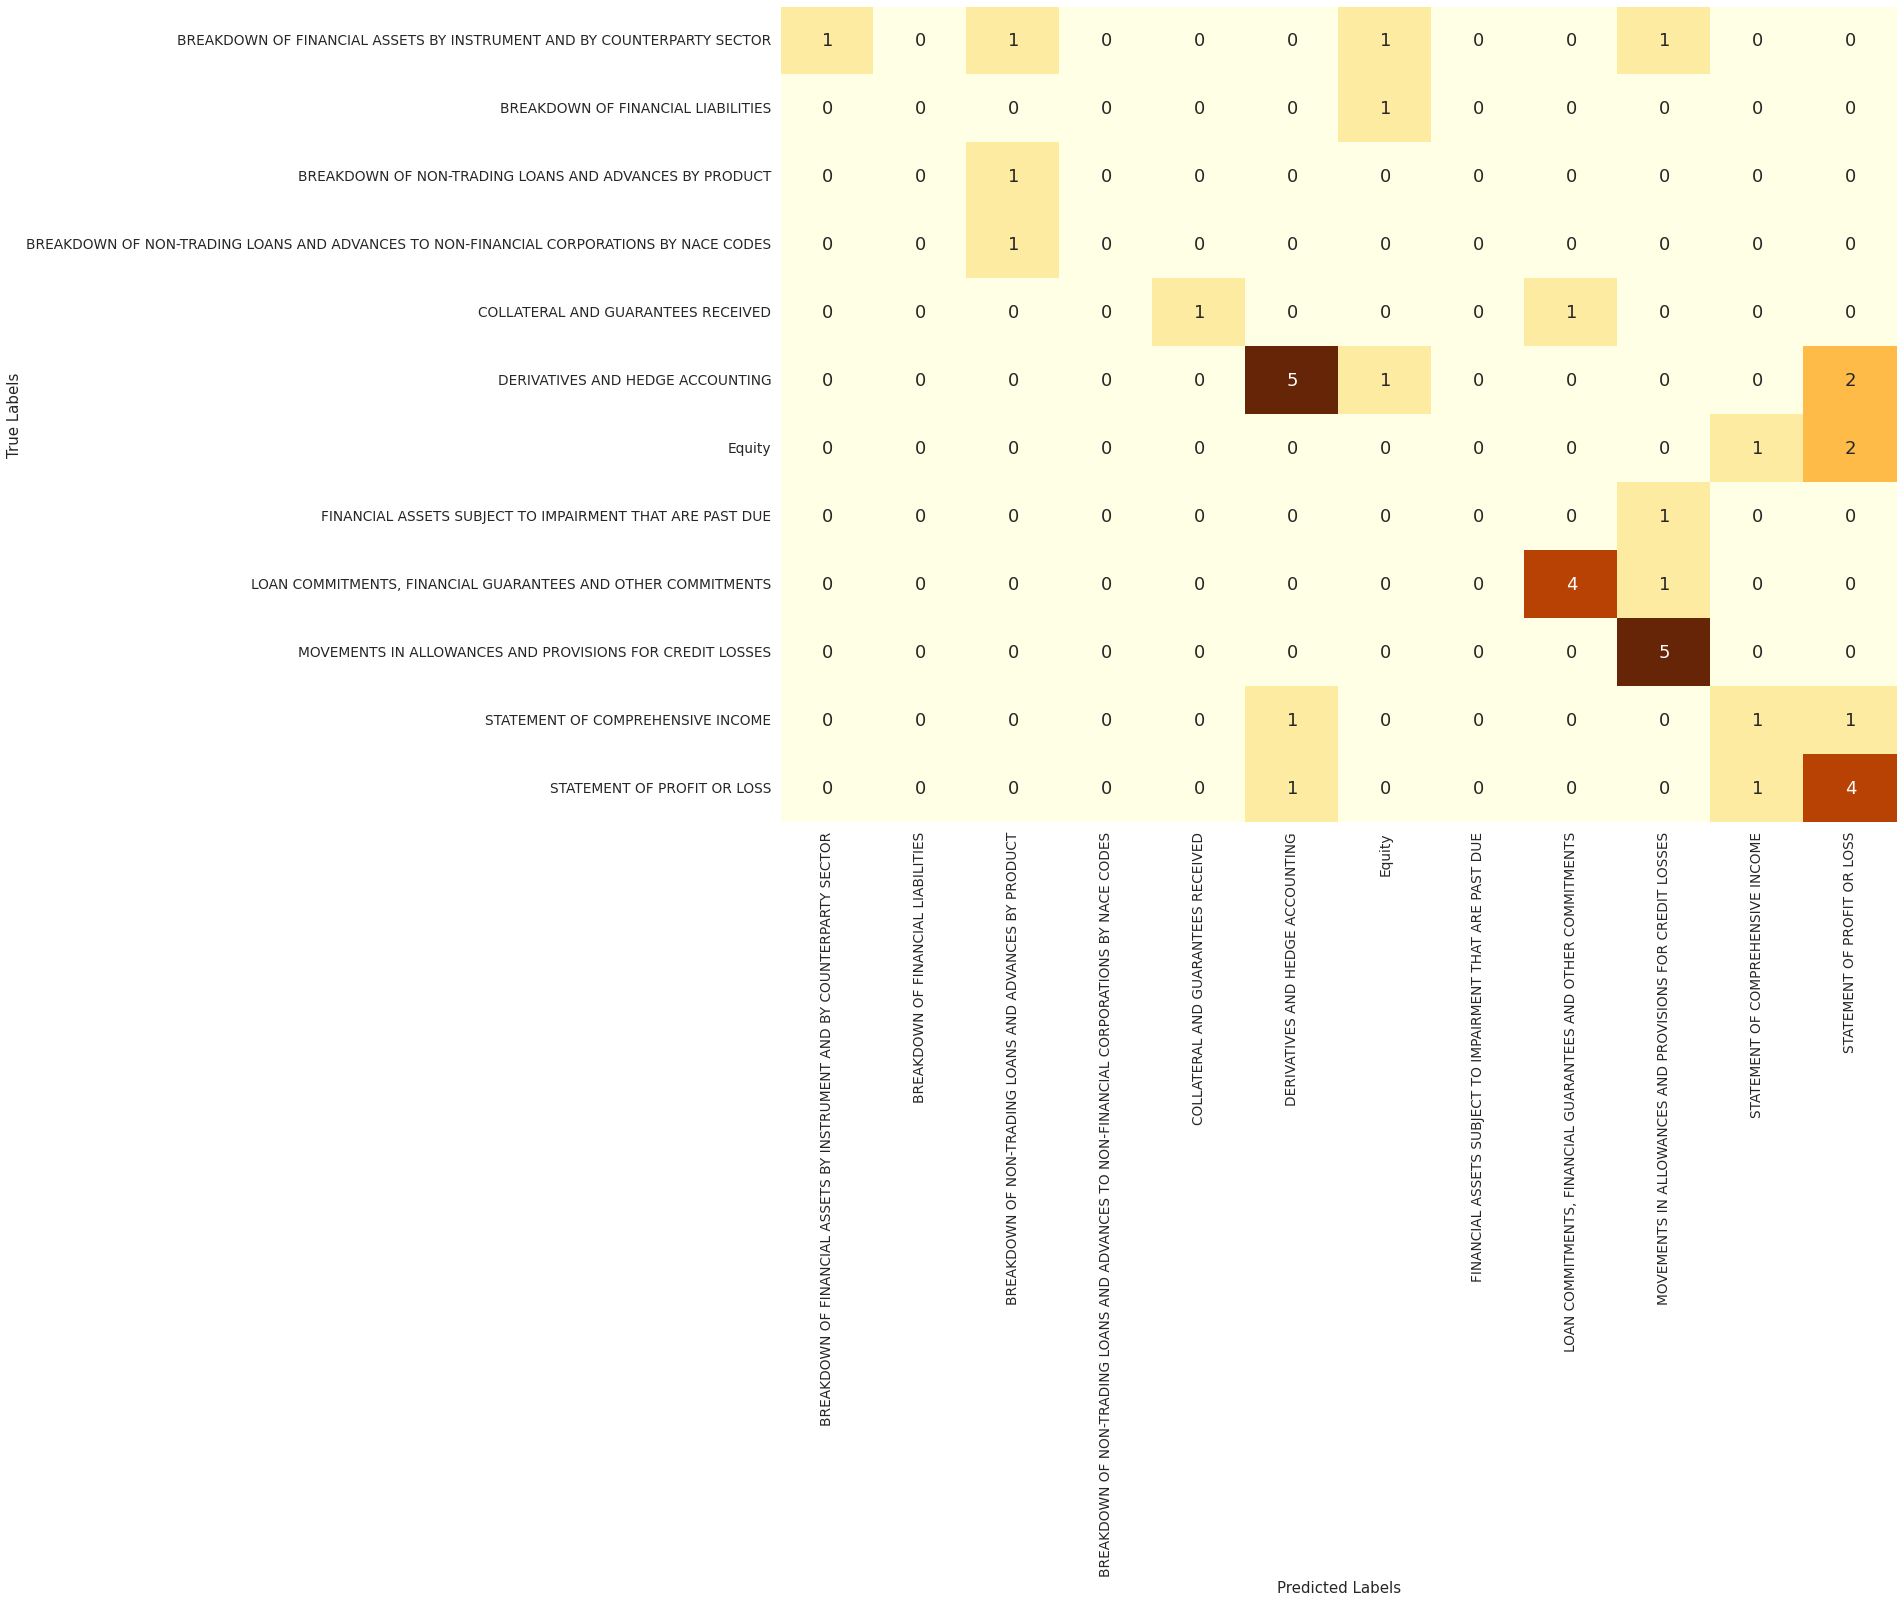

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = top3_df["true_label"].to_list() 
Predicted_labels = top3_df["predicted_label_1"].to_list() 
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
sns.set(font_scale=1.25)
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr",annot_kws={"size": 18})
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

In [ ]:
#Display Classification Report
from sklearn.metrics import classification_report
print(classification_report(True_labels, Predicted_labels,zero_division=0))

                                                                                         precision    recall  f1-score   support

                 BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AND BY COUNTERPARTY SECTOR       1.00      0.25      0.40         4
                                                     BREAKDOWN OF FINANCIAL LIABILITIES       0.00      0.00      0.00         1
                                 BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY PRODUCT       0.33      1.00      0.50         1
BREAKDOWN OF NON-TRADING LOANS AND ADVANCES TO NON-FINANCIAL CORPORATIONS BY NACE CODES       0.00      0.00      0.00         1
                                                     COLLATERAL AND GUARANTEES RECEIVED       1.00      0.50      0.67         2
                                                       DERIVATIVES AND HEDGE ACCOUNTING       0.71      0.62      0.67         8
                                                                                 Equity       0.

In [ ]:
# Calculate the First Prediction Percentages
top3_df["First_Prediction_Percentage"] = (top3_df["true_label"]  == top3_df['predicted_label_1']) * 100
# Calculate the First and Second Prediction Percentages
top3_df["First_and_Second_Prediction_Percentage"] = ((top3_df["true_label"]  == top3_df['predicted_label_1']) |((top3_df["true_label"]  == top3_df['predicted_label_2']))) * 100

In [ ]:
# Calculate the accuracy of First and Second Predictions
accuracy_df = top3_df.loc[:,['true_label',"First_Prediction_Percentage", "First_and_Second_Prediction_Percentage"]].groupby('true_label').mean() 
accuracy_df 

,First_Prediction_Percentage,First_and_Second_Prediction_Percentage
true_label,,
BREAKDOWN OF FINANCIAL ASSETS BY INSTRUMENT AND BY COUNTERPARTY SECTOR,25.000000,25.000000
BREAKDOWN OF FINANCIAL LIABILITIES,0.000000,0.000000
BREAKDOWN OF NON-TRADING LOANS AND ADVANCES BY PRODUCT,100.000000,100.000000
BREAKDOWN OF NON-TRADING LOANS AND ADVANCES TO NON-FINANCIAL CORPORATIONS BY NACE CODES,0.000000,0.000000
COLLATERAL AND GUARANTEES RECEIVED,50.000000,50.000000
DERIVATIVES AND HEDGE ACCOUNTING,62.500000,75.000000
Equity,0.000000,0.000000
FINANCIAL ASSETS SUBJECT TO IMPAIRMENT THAT ARE PAST DUE,0.000000,0.000000
"LOAN COMMITMENTS, FINANCIAL GUARANTEES AND OTHER COMMITMENTS",80.000000,80.000000
